In [1]:
# import libraries
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,TensorDataset
import torch.nn.functional as F

# Upgrade sympy to prevent potential compatibility issues with torch
!pip install --upgrade sympy

In [2]:
# import dataset
import pandas as pd
iris = pd.read_csv('https://raw.githubusercontent.com/mwaskom/seaborn-data/master/iris.csv')

In [4]:
# organize the data

# convert from pandas dataframe to tensor
data = torch.tensor( iris[iris.columns[0:4]].values ).float()

# transform species to number
labels = torch.zeros(len(data), dtype=torch.long)
# labels[iris.species=='setosa']   = 0 # don't need!
labels[iris.species=='versicolor'] = 1
labels[iris.species=='virginica']  = 2

# EXPERIMENT

In [14]:
# Mini batches sizes
miniBatchSizes = []
trainLoaders = []

n = 6

for i in range(n):
  miniBatchSizes.append(2**(i + 1))

print(miniBatchSizes)

[2, 4, 8, 16, 32, 64]


In [6]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(data, labels, test_size=.2)


# then convert them into PyTorch Datasets (note: already converted to tensors)
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)


for i in range(n):
  batchsize = 2**(i + 1)
  train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
  trainLoaders.append(train_loader)

test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

print(trainLoaders)

[<torch.utils.data.dataloader.DataLoader object at 0x7d9e8c2b4e30>, <torch.utils.data.dataloader.DataLoader object at 0x7d9e87a83260>, <torch.utils.data.dataloader.DataLoader object at 0x7d9e87037200>, <torch.utils.data.dataloader.DataLoader object at 0x7d9e86c67350>, <torch.utils.data.dataloader.DataLoader object at 0x7d9e86c670e0>, <torch.utils.data.dataloader.DataLoader object at 0x7d9e86c66720>]


# Construct the model and training plans

In [7]:
# a function that creates the ANN model

def createANewModel():

  # model architecture
  ANNiris = nn.Sequential(
      nn.Linear(4,64),   # input layer
      nn.ReLU(),         # activation unit
      nn.Linear(64,64),  # hidden layer
      nn.ReLU(),         # activation unit
      nn.Linear(64,3),   # output units
        )

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.SGD(ANNiris.parameters(),lr=.0005)

  return ANNiris,lossfun,optimizer

In [8]:
# train the model

# global parameter
numepochs = 250

def trainTheModel(trainLoader):

  # initialize accuracies as empties
  trainAcc = []
  testAcc  = []
  losses   = []

  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in trainLoader:

      # forward pass and loss
      yHat = ANNiris(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # compute training accuracy just for this batch
      batchAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
      batchLoss.append( loss.item() )
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )
    losses.append( np.mean(batchLoss) )

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    predlabels = torch.argmax( ANNiris(X),axis=1 )
    testAcc.append( 100*torch.mean((predlabels == y).float()).item() )

  # function output
  return trainAcc,testAcc,losses

In [9]:
# Define a smoothing function for plotting
def smooth(data, window_size):
    if len(data) == 0:
        return np.array([])
    if window_size <= 1:
        return np.array(data)
    # Use 'same' mode to keep the output length the same as the input
    return np.convolve(data, np.ones(window_size)/window_size, mode='same')

# Result matrices
accuracyResultsTrain = np.zeros((numepochs,len(miniBatchSizes)))
accuracyResultsTest = np.zeros((numepochs,len(miniBatchSizes)))

for i in range(n):
  # Create the model
  ANNiris,lossfun,optimizer = createANewModel()

  # Train the model
  trainAcc,testAcc,losses = trainTheModel(trainLoaders[i])

  # Store data
  accuracyResultsTrain[:,i] = smooth(trainAcc,10)
  accuracyResultsTest[:,i]  = smooth(testAcc,10)

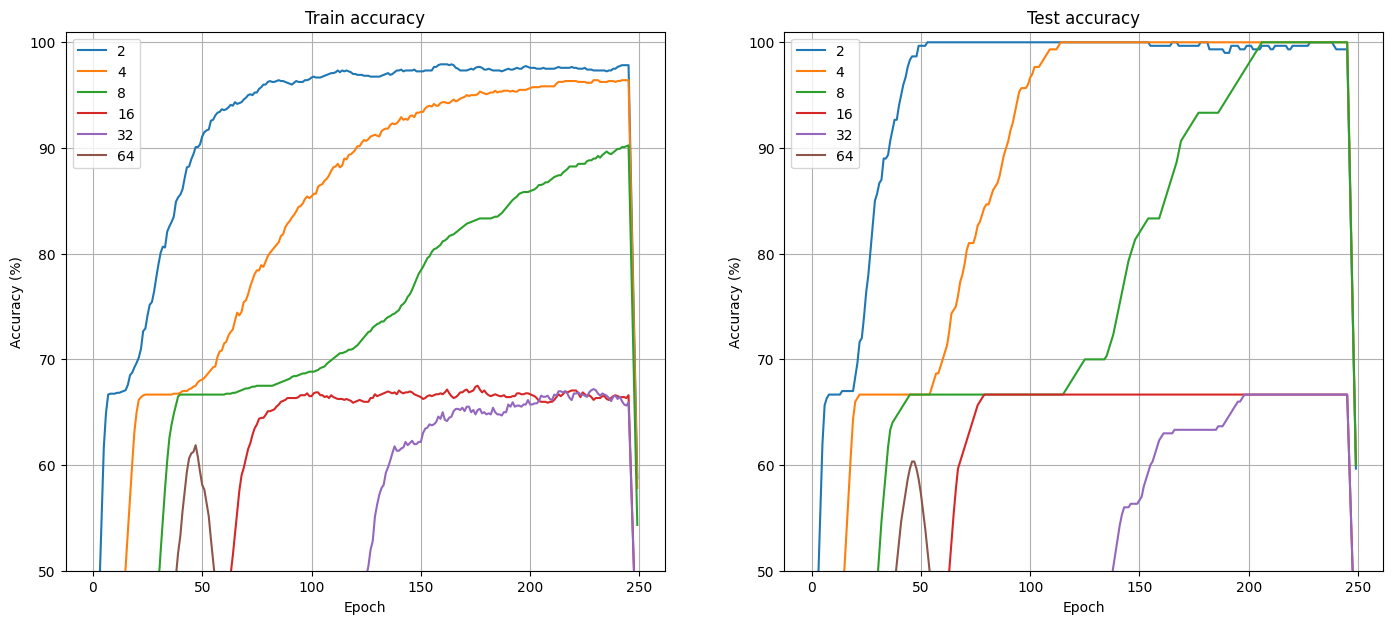

In [12]:
# plot some results
fig,ax = plt.subplots(1,2,figsize=(17,7))

ax[0].plot(accuracyResultsTrain)
ax[0].set_title('Train accuracy')
ax[1].plot(accuracyResultsTest)
ax[1].set_title('Test accuracy')

# make the legend easier to read
leglabels = miniBatchSizes

# common features
for i in range(2):
  ax[i].legend(leglabels)
  ax[i].set_xlabel('Epoch')
  ax[i].set_ylabel('Accuracy (%)')
  ax[i].set_ylim([50,101])
  ax[i].grid()

plt.show()